What's done: can merge two EfficientNetB0
TO DO: merge two EfficientNet with less layers
TO DO: merge two input layers only


In [77]:
# Kaggle: Recursion Cellular Image Classification
# https://www.kaggle.com/leighplt/densenet121-pytorch
# https://stackoverflow.com/questions/43264816/need-help-combining-two-3-channel-images-into-6-channel-image-python
# https://www.pyimagesearch.com/2019/06/24/change-input-shape-dimensions-for-fine-tuning-with-keras/
# https://github.com/keras-team/keras/issues/4664
# https://www.machinecurve.com/index.php/2019/10/18/a-simple-conv3d-example-with-keras/

# Efficientnet
# https://www.dlology.com/blog/transfer-learning-with-efficientnet/
# https://github.com/titu1994/keras-efficientnets

# Concatenate layers
# https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
# https://datascience.stackexchange.com/questions/26103/merging-two-different-models-in-keras

import os
import numpy as np
np.random.seed(251)
os.environ['PYTHONHASHSEED']=str(251)
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D, Input, concatenate
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import class_weight
from keras_efficientnets import EfficientNetB0, EfficientNet, BlockArgs

In [78]:
project_path = r'D:\UCBerkeley\CourseWork\202001\W251\Homework\Project'
dir_openpose = 'openpose_output'
dir_train = 'NEW4_image_transfer_trial4'
dir_test = 'NEW4_manual_optical_flow_output_trial4'
model_name = 'Efficientnet_model_weights_NEW4_trial4_model4.h5'

TRAIN_DIR = os.path.join(project_path, dir_openpose, dir_train)
# class_list = ['AGAIN', 'ALL', 'AWKWARD', 'BASEBALL', 'BEHAVIOR', 'CAN', 'CHAT', 'CHEAP', 
#               'CHEAT', 'CHURCH', 'COAT', 'CONFLICT', 'COURT', 'DEPOSIT', 'DEPRESS', 
#               'DOCTOR', 'DRESS', 'ENOUGH', 'NEG']
y_train_lst = [f.split('_')[1] for f in os.listdir(os.path.join(project_path, dir_openpose, dir_test)) if 'train' in f]
class_list = np.unique(y_train_lst)
sample_class_weights = class_weight.compute_class_weight('balanced', class_list, y_train_lst)

HEIGHT = 224
WIDTH = 224

BATCH_SIZE = 16
NUM_EPOCHS = 10
num_train_images = len([f for f in os.listdir(os.path.join(project_path, dir_openpose, dir_test)) 
                        if 'train' in f])
print(num_train_images)

2205


In [79]:
# Reference: https://github.com/titu1994/keras-efficientnets/blob/ea5fa5a3703d25c796f4899c2d018eef6ed52d6c/keras_efficientnets/config.py#L123
DEFAULT_BLOCK_LIST = [
        BlockArgs(32, 16, kernel_size=3, strides=(1, 1), num_repeat=1, se_ratio=0.25, expand_ratio=1),
        BlockArgs(16, 24, kernel_size=3, strides=(2, 2), num_repeat=2, se_ratio=0.25, expand_ratio=6),
        BlockArgs(24, 40, kernel_size=5, strides=(2, 2), num_repeat=2, se_ratio=0.25, expand_ratio=6),
        BlockArgs(40, 80, kernel_size=3, strides=(2, 2), num_repeat=3, se_ratio=0.25, expand_ratio=6),
        BlockArgs(80, 112, kernel_size=5, strides=(1, 1), num_repeat=3, se_ratio=0.25, expand_ratio=6),
        BlockArgs(112, 192, kernel_size=5, strides=(2, 2), num_repeat=4, se_ratio=0.25, expand_ratio=6),
        BlockArgs(192, 320, kernel_size=3, strides=(1, 1), num_repeat=1, se_ratio=0.25, expand_ratio=6),
    ]

block_lst = [
        BlockArgs(32, 16, kernel_size=3, strides=(1, 1), num_repeat=1, se_ratio=0.25, expand_ratio=1),
        BlockArgs(16, 24, kernel_size=3, strides=(2, 2), num_repeat=2, se_ratio=0.25, expand_ratio=6),
        BlockArgs(24, 40, kernel_size=5, strides=(2, 2), num_repeat=2, se_ratio=0.25, expand_ratio=6),
        BlockArgs(40, 80, kernel_size=3, strides=(2, 2), num_repeat=3, se_ratio=0.25, expand_ratio=6),
        BlockArgs(80, 112, kernel_size=5, strides=(1, 1), num_repeat=3, se_ratio=0.25, expand_ratio=6)
    ]

In [71]:
# Use width_coefficient and depth_coefficient from EfficientNetB0
# EfficientNet source code: https://github.com/titu1994/keras-efficientnets/blob/ea5fa5a3703d25c796f4899c2d018eef6ed52d6c/keras_efficientnets/efficientnet.py#L212
# base_model1 = EfficientNet(input_shape=(HEIGHT, WIDTH, 3), 
#                            block_args_list=block_lst, 
#                            width_coefficient=1.0, depth_coefficient=1.0, 
#                            include_top=False)
base_model1 = EfficientNetB0(input_shape=(HEIGHT, WIDTH, 3), include_top=False, weights='imagenet')
base_output1 = base_model1.layers[-1].output
added1 = GlobalAveragePooling2D()(base_output1)
# 
# base_model2 = EfficientNet(input_shape=(HEIGHT, block_lst, 3), 
#                            block_args_list=DEFAULT_BLOCK_LIST, 
#                            width_coefficient=1.0, depth_coefficient=1.0, 
#                            include_top=False)
base_model2 = EfficientNetB0(input_shape=(HEIGHT, WIDTH, 3), include_top=False, weights='imagenet')
base_output2 = base_model2.layers[-1].output
added2 = GlobalAveragePooling2D()(base_output2)

combined_output = concatenate([added1, added2])
combined_output_dropout = Dropout(0.2)(combined_output)
output_layer = Dense(19, activation='softmax')(combined_output_dropout)

merged_model = Model(input=[base_model1.input, base_model2.input], output=output_layer)

merged_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.00001),
              metrics=['accuracy'])
merged_model.summary()

C:\Users\Angela\Anaconda3\envs\w251_project3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_37 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_2008 (Conv2D)            (None, 112, 112, 32) 864         input_36[0][0]                   
__________________________________________________________________________________________________
conv2d_2073 (Conv2D)            (None, 112, 112, 32) 864         input_37[0][0]                   
___________________________________________________________________________________________

In [83]:
# NOT WORKING
# Reference: https://stackoverflow.com/questions/50136032/modify-layers-in-resnet-model
input_layer = Input(shape=(None, 224, 224, 3), name="input_1")
base_model = EfficientNetB0(input_shape=(HEIGHT, WIDTH, 3), include_top=False, weights='imagenet')
base_model.layers.pop(0)
output = base_model(input_layer)
base_output = output.layers[-1].output
model = Model(input_layer, base_output)
base_model.summary()

ValueError: strides should be of length 1, 3 or 5 but was 2

In [ ]:
# Reference: https://keras.io/preprocessing/image/
# Reference: https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
train_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    # Below are the parameters used for crop
    # zoom_range=[0.8, 1.2], 
    # width_shift_range=[-50,50]
    # Below are the parameters used for no crop
    zoom_range=[0.7, 1.3], 
    # width shift means up and down
    width_shift_range=0.2,
    height_shift_range = 0.2
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE)
model1 = Sequential()
base_model = EfficientNetB0(input_shape=(HEIGHT, WIDTH, 3), include_top=False, weights='imagenet')
base_model.add
base_output = base_model.layers[-1].output
added = Add(GlobalAveragePooling2D)(base_output)
base_model2 = EfficientNetB0(input_shape=(HEIGHT, WIDTH, 3), include_top=False, weights='imagenet')
base_output2 = base_model2.layers[-1].output
# base_model.layers.pop(0)
# base_model = Model(Input(shape=(None, 224, 224, 3), name="input_1"), output=base_output)
# for layer in base_model.layers:
merged_model = Model(input=[base_model.input, base_model2.input], output=[added, base_output2])
#     layer.trainable = False
    
# base_model.trainable = True
# set_trainable = False
# for layer in base_model.layers:
#     if layer.name in ['res5c_branch2b', 'bn5c_branch2b', 'res5c_branch2c', 'bn5c_branch2c']:
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False
#         
# layers = [(layer, layer.name, layer.trainable) for layer in base_model.layers]
# pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']).tail(10)

In [ ]:
merged_model.summary()

In [7]:
# test_config = base_model.get_layer('input_1').get_config()
# test_config['batch_input_shape'] = (None, 300, 300, 6)
# print(test_config)
# test_config = base_model.get_layer('conv2d_1').get_config()
# # test_config['batch_input_shape'] = (None, 300, 300, 6)
# print(test_config)
# test_config = base_model.get_layer('batch_normalization_1').get_config()
# # test_config['batch_input_shape'] = (None, 300, 300, 6)
# print(test_config)
# base_model.summary()

{'batch_input_shape': (None, 300, 300, 6), 'dtype': 'float32', 'sparse': False, 'name': 'input_1'}
{'name': 'conv2d_1', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (2, 2), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'EfficientNetConvInitializer', 'config': {}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
{'name': 'batch_normalization_1', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones

In [34]:
model = Sequential()
model.add(merged_model)
# GlobalAveragePooling2D is what the original resnet50 uses
model.add(GlobalAveragePooling2D(name="gap"))
# The original resnet50 does not have a dropout here
model.add(Dropout(0.2))
model.add(Dense(len(class_list), activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.00001),
              metrics=['accuracy'])
model.summary()

ValueError: Layer model_10 expects 2 inputs, but it received 1 input tensors. Input received: [<tf.Tensor 'model_10_input:0' shape=(None, 224, 224, 3) dtype=float32>]

In [13]:
filepath=os.path.join(project_path, model_name)
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]
history = model.fit_generator(train_generator, epochs=NUM_EPOCHS, 
                              steps_per_epoch=num_train_images // BATCH_SIZE, 
                              shuffle=True, 
                              class_weight=dict(enumerate(sample_class_weights)), 
                              callbacks=callbacks_list)

Epoch 1/10
137/137 [==============================] - 270s 2s/step - loss: 3.0025 - accuracy: 0.0795

Epoch 00001: saving model to D:\UCBerkeley\CourseWork\202001\W251\Homework\Project\ResNet50_model_weights_NEW4_trial4_model4.h5
Epoch 2/10
137/137 [==============================] - 266s 2s/step - loss: 2.6083 - accuracy: 0.1836

Epoch 00002: saving model to D:\UCBerkeley\CourseWork\202001\W251\Homework\Project\ResNet50_model_weights_NEW4_trial4_model4.h5
Epoch 3/10
137/137 [==============================] - 266s 2s/step - loss: 2.3531 - accuracy: 0.3024

Epoch 00003: saving model to D:\UCBerkeley\CourseWork\202001\W251\Homework\Project\ResNet50_model_weights_NEW4_trial4_model4.h5
Epoch 4/10
137/137 [==============================] - 266s 2s/step - loss: 2.1324 - accuracy: 0.4002

Epoch 00004: saving model to D:\UCBerkeley\CourseWork\202001\W251\Homework\Project\ResNet50_model_weights_NEW4_trial4_model4.h5
Epoch 5/10
137/137 [==============================] - 267s 2s/step - loss: 1.892

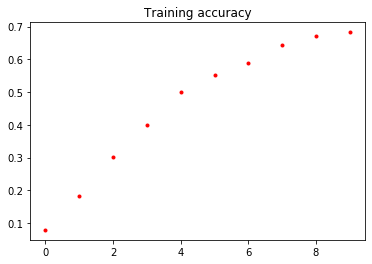

In [14]:
# Plot the training and validation loss + accuracy
def plot_training(history):
    acc = history.history['accuracy']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.title('Training accuracy')
    plt.show()

plot_training(history)


In [23]:
from keras.preprocessing import image
import numpy as np
from keras.models import load_model
model_saved = load_model(os.path.join(project_path, model_name))
def conv_index_to_vocab(ind):
    temp_dict = dict(enumerate(class_list))
    return temp_dict[ind]
def conv_vocab_to_index(vocab):
    temp_dict = dict(zip(class_list,range(len(class_list))))
    return temp_dict[vocab]

print(conv_index_to_vocab(0))
print(conv_vocab_to_index('NEG'))

AGAIN
18


In [24]:
correct_count = 0
count = 0
test_files_lst = [f for f in os.listdir(os.path.join(project_path, dir_openpose, dir_test)) 
                  if 'test' in f and 'sim0' in f]
# test_files_lst = [f for f in os.listdir(os.path.join(project_path, dir_openpose, dir_test)) 
#                   if 'test' in f]
for file in test_files_lst:
    img = image.load_img(os.path.join(project_path,dir_openpose, dir_test,file), target_size=(HEIGHT, WIDTH))
    x = image.img_to_array(img)
    # print(x.shape)
    x = np.expand_dims(x, axis=0)
    # print(x.shape)
    x = preprocess_input(x)
    y_pred = model_saved.predict(x)
    print('-----------------')
    print('Actual: ', file.split('_')[1])
    print('Prediction: ', conv_index_to_vocab(np.argmax(y_pred)))
    # print(y_pred)
    count += 1
    if file.split('_')[1] == conv_index_to_vocab(np.argmax(y_pred)):
        correct_count += 1 

-----------------
Actual:  AGAIN
Prediction:  BEHAVIOR
-----------------
Actual:  ALL
Prediction:  ALL
-----------------
Actual:  AWKWARD
Prediction:  BEHAVIOR
-----------------
Actual:  BASEBALL
Prediction:  ENOUGH
-----------------
Actual:  BEHAVIOR
Prediction:  BEHAVIOR
-----------------
Actual:  CAN
Prediction:  CHAT
-----------------
Actual:  CHAT
Prediction:  CHAT
-----------------
Actual:  CHAT
Prediction:  BEHAVIOR
-----------------
Actual:  CHEAP
Prediction:  BASEBALL
-----------------
Actual:  CHEAT
Prediction:  CONFLICT
-----------------
Actual:  CHEAT
Prediction:  BEHAVIOR
-----------------
Actual:  CHURCH
Prediction:  CHURCH
-----------------
Actual:  COAT
Prediction:  COAT
-----------------
Actual:  COAT
Prediction:  ALL
-----------------
Actual:  CONFLICT
Prediction:  BEHAVIOR
-----------------
Actual:  COURT
Prediction:  COURT
-----------------
Actual:  DEPOSIT
Prediction:  COURT
-----------------
Actual:  DEPRESS
Prediction:  DOCTOR
-----------------
Actual:  DOCTOR
Pr

In [25]:
print('Accuracy = ', correct_count/len(test_files_lst))


Accuracy =  0.391304347826087
